# Extracting covariance model parameters from Intel lab data

In this Notebook, we analyse data provided by the [Intel Berkeley Research laboratory](http://db.csail.mit.edu/labdata/labdata.html) to extract scaling parameters for the covariance models for our paper entitled "Using Correlated Information to Extend Device Lifetime in the Internet of Things" . To extract the covariance models paramaters we follow Tilmanm  Gneiting instructions as presented in his paper: [Nonseparable, stationary Covariance Functions for Space-Time Data](http://www.jstor.org/stable/3085674). [Our code](https://github.com/hribarjernej89/Nonseparable_Stationary_Covariance_Functions_for_Space-Time_Data) replicating his experiment.

We use temperature and humidity measurements from nine sensors to extract covariance models scaling parameters. We focus only on a subset of available sensors residing in one single room because only sensors deployed in the same room are subject to the same environmental factors, e.g. air circulation. We average multiple updates over an hour to provide time domain consistency necessary to calculate temporal correlation. We start by calculating space-time correlation for time lag zero. At time lag zero we compare measurements acquired at the same hour To obtain empirical temporal correlation, we calculate the average of empirical space-time correlation for a specific time-lag. It is noticeable that humidity has a better temporal correlation in comparison to temperature. In a case for humidity data is correlated even when time lag is nine hours, in contrast to temperature empirical correlation that is negligible after six hours. In the next step, we fitted the models to data points. All three covariance models provide a reasonable fit, indicating that all three models are applicable in these two particular scenarios. 

## Temperature: 


\begin{equation}
\rho_i^{_{I}}(r_i,t_i) = exp(-0.012 r_i - 0.272 \Delta_i(t)),
\end{equation}

\begin{equation}
\rho_i^{_{II}}(r_i,t_i) =   \frac{0.103\Delta_i(t)+1}{\bigg( (0.103\Delta_i(t)+1)^2 + 0.017^2 r_i^2\bigg)^{2}},
\end{equation}

\begin{equation}
\rho_i^{_{III}}(r_i,t_i) = \exp (- 0.022^2 r_i^2 - 0.039\Delta_i(t)- 0.003 \Delta_i(t) r_i^2).
\end{equation}


The best fit to empirical points is separable model $\rho_i^{_{I}}$.

## Humidity:

\begin{equation}
\rho_i^{_{I}}(r_i,t_i) = exp(-0.166 r_i - 0.009 \Delta_i(t)),
\end{equation}

\begin{equation}
\rho_i^{_{II}}(r_i,t_i) =   \frac{0.062\Delta_i(t)+1}{\bigg( (0.062\Delta_i(t)+1)^2 + 0.016^2 r_i^2\bigg)^{2}},
\end{equation}

\begin{equation}
\rho_i^{_{III}}(r_i,t_i) = \exp (- 0.021^2 r_i^2 - 0.022\Delta_i(t)- 0.002\Delta_i(t) r_i^2).
\end{equation}

For humidty the best fit to empirical points is  non-separable $\rho_i^{_{II}}$.



![Results.svg](attachment:Results.svg)

In [1]:
#Import statements
%matplotlib inline 
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import datetime
import scipy.integrate as integrate

from scipy.optimize import curve_fit

pd.options.display.max_rows = 12


# Graphing helper function
def setup_graph(title='', x_label='', y_label='', fig_size=None):
    fig = plt.figure()
    if fig_size != None:
        fig.set_size_inches(fig_size[0], fig_size[1])
    ax = fig.add_subplot(111)
    ax.set_title(title)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)

In [2]:
df = pd.read_csv('Intel_data.txt', names=["Date" ,"Time", "Epoch", "Mote_id", "Temperature",
                                          "Humidity", "Light", "Voltage" ], parse_dates=[['Date', 'Time']],sep=" ",)
df.index = pd.to_datetime(df['Date_Time'])

In [3]:
#We limit our observations only to a handfull of days
new = df['2004/3/1':'2004/3/21']

df2 = pd.DataFrame()
test = pd.DataFrame()

test = new.loc[df.Mote_id==14]
test = test.groupby([test.index.year,test.index.month,test.index.day, test.index.hour]).mean()
df2[['Node14']] = test[['Temperature']]

print(df2)

test = new.loc[df.Mote_id==25]
test = test.groupby([test.index.year,test.index.month,test.index.day, test.index.hour]).mean()
df2[['Node25']] = test[['Temperature']]

print(df2)


                                            Node14
Date_Time Date_Time Date_Time Date_Time           
2004      3         1         0          18.892649
                              1          17.828778
                              2          17.478076
                              3          17.265336
                              4          16.976067
                              5          16.678958
...                                            ...
                    21        18         21.580820
                              19         21.213658
                              20         20.893717
                              21         20.408241
                              22         20.171971
                              23         19.997640

[463 rows x 1 columns]
                                            Node14     Node25
Date_Time Date_Time Date_Time Date_Time                      
2004      3         1         0          18.892649  17.859044
                         

In [4]:
#We limit our observations only to a handfull od days
new = df['2004/3/1':'2004/3/21']

#We create two datafranes ti hold the data used for covariance calculations
Temperature_data = pd.DataFrame()
Humidity_data = pd.DataFrame()
test = pd.DataFrame()

#Write data from Node 14
test = new.loc[df.Mote_id==14]
test = test.groupby([test.index.year,test.index.month,test.index.day, test.index.hour]).mean()
Temperature_data [['Node14']] = test[['Temperature']]
Humidity_data[['Node14']] = test[['Humidity']]

#Write data from Nodes 22 to 29
for i in range(8):
    j = i + 22
    test = new.loc[df.Mote_id==j]
    test = test.groupby([test.index.year,test.index.month,test.index.day, test.index.hour]).mean()
    Temperature_data[['Node' + str(j)]] = test[['Temperature']]
    Humidity_data[['Node'+ str(j)]] = test[['Humidity']]


#print(Temperature_data)
#print(Humidity_data)

In [5]:
nodes_distances = pd.read_csv('intel_nodes_distances.csv')
#print(nodes_distances)

(0, 1)

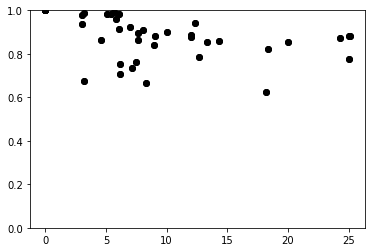

In [6]:
# calculating the covariance for zero lag for temperature
i = 0

ty0 = [None] * 81
tx0 = [None] * 81
k=0
for first_column in Temperature_data:
    df1 = Temperature_data[first_column]
    std_test1=np.std(df1)
    j = 0 
    for second_column in Temperature_data:
        df2 = Temperature_data[second_column]
        std_test2=np.std(df2)
        ty0[k] = np.corrcoef(df1, df2)[0, 1]
        tx0[k] = nodes_distances.iloc[i,j]
        j = j + 1
        k = k + 1
    i = i + 1
plt.scatter(tx0, ty0,  color='black')
plt.ylim(0, 1)

(0, 1)

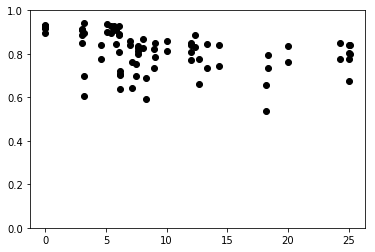

In [7]:
# calculating the covariance for lag 1 hour for temperature
i = 0

ty1 = [None] * 81
tx1 = [None] * 81
k=0
for first_column in Temperature_data:
    df1 = Temperature_data[first_column][:-1]
    std_test1=np.std(df1)
    j = 0 
    for second_column in Temperature_data:
        df2 = Temperature_data[second_column][1:]
        std_test2=np.std(df2)
        ty1[k] = np.corrcoef(df1, df2)[0, 1]
        tx1[k] = nodes_distances.iloc[i,j]
        j = j + 1
        k = k + 1
    i = i + 1
plt.scatter(tx1, ty1,  color='black')
plt.ylim(0, 1)

(0, 1)

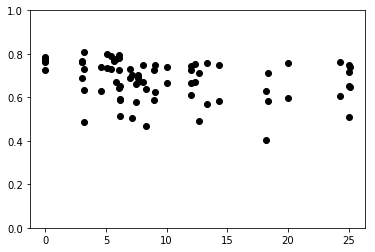

In [8]:
# calculating the covariance for lag 2 hour for temperature
i = 0

ty2 = [None] * 81
tx2 = [None] * 81
k=0
for first_column in Temperature_data:
    df1 = Temperature_data[first_column][:-2]
    std_test1=np.std(df1)
    j = 0 
    for second_column in Temperature_data:
        df2 = Temperature_data[second_column][2:]
        std_test2=np.std(df2)
        ty2[k] = np.corrcoef(df1, df2)[0, 1]
        tx2[k] = nodes_distances.iloc[i,j]
        j = j + 1
        k = k + 1
    i = i + 1
plt.scatter(tx2, ty2,  color='black')
plt.ylim(0, 1)

(0, 1)

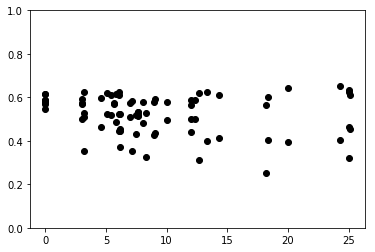

In [9]:
# calculating the covariance for lag 3 hour for temperature
i = 0

ty3 = [None] * 81
tx3 = [None] * 81
k=0
for first_column in Temperature_data:
    df1 = Temperature_data[first_column][:-3]
    std_test1=np.std(df1)
    j = 0 
    for second_column in Temperature_data:
        df2 = Temperature_data[second_column][3:]
        std_test2=np.std(df2)
        ty3[k] = np.corrcoef(df1, df2)[0, 1]
        tx3[k] = nodes_distances.iloc[i,j]
        j = j + 1
        k = k + 1
    i = i + 1
plt.scatter(tx3, ty3,  color='black')
plt.ylim(0, 1)

(0, 1)

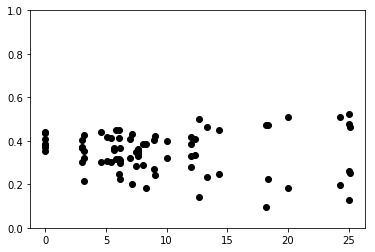

In [10]:
# calculating the covariance for lag 4 hour for temperature
i = 0

ty4 = [None] * 81
tx4 = [None] * 81
k=0
for first_column in Temperature_data:
    df1 = Temperature_data[first_column][:-4]
    std_test1=np.std(df1)
    j = 0 
    for second_column in Temperature_data:
        df2 = Temperature_data[second_column][4:]
        std_test2=np.std(df2)
        ty4[k] = (np.cov(df1,df2)/(std_test1*std_test2)).item((0, 1))
        tx4[k] = nodes_distances.iloc[i,j]
        j = j + 1
        k = k + 1
    i = i + 1
plt.scatter(tx4, ty4,  color='black')
plt.ylim(0, 1)

(0, 1)

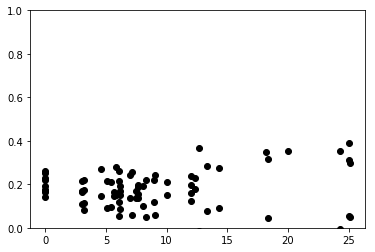

In [11]:
# calculating the covariance for lag 5 hour for temperature
i = 0

ty5 = [None] * 81
tx5 = [None] * 81
k=0
for first_column in Temperature_data:
    df1 = Temperature_data[first_column][:-5]
    std_test1=np.std(df1)
    j = 0 
    for second_column in Temperature_data:
        df2 = Temperature_data[second_column][5:]
        std_test2=np.std(df2)
        ty5[k] = np.corrcoef(df1, df2)[0, 1]
        tx5[k] = nodes_distances.iloc[i,j]
        j = j + 1
        k = k + 1
    i = i + 1
plt.scatter(tx5, ty5,  color='black')
plt.ylim(0, 1)

In [12]:
#Temperature time lags from 6 to 9

lists_hy = []
lists_hx = []
    
for z in range(4):
    humy = [None] * 81
    humx = [None] * 81
    k=0
    i=0
    for first_column in Temperature_data:
        df1 = Temperature_data[first_column][:-(6+z)]
        std_test1=np.std(df1)
        j = 0 
        for second_column in Temperature_data:
            df2 = Temperature_data[second_column][(6+z):]
            std_test2=np.std(df2)
            humy[k] = np.corrcoef(df1, df2)[0, 1]
            humx[k] = nodes_distances.iloc[i,j]
            j = j + 1
            k = k + 1
        i = i + 1
    lists_hy.append(humy)
    lists_hx.append(humx)

ty6 = lists_hy[0]
tx6 = lists_hx[0]
ty7 = lists_hy[1]
tx7 = lists_hx[1]
ty8 = lists_hy[2]
tx8 = lists_hx[2]
ty9 = lists_hy[3]
tx9 = lists_hx[3]

In [13]:
#Calculating average distance
average_distance = sum(tx1)/len(tx1)

print(average_distance)
#print(temperature_timey)


9.318518518518522


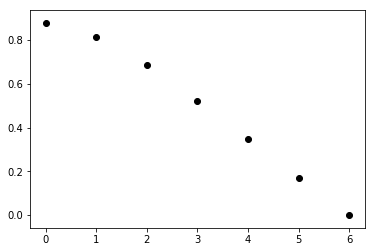

In [14]:
#Calculating averages for time component:
temperature_timey = [sum(ty0)/len(ty0),sum(ty1)/len(ty1), sum(ty2)/len(ty2),sum(ty3)/len(ty3),sum(ty4)/len(ty4),sum(ty5)/len(ty5),
                 sum(ty6)/len(ty6)]#,sum(ty7)/len(ty7),sum(ty8)/len(ty8),sum(ty9)/len(ty9)]

#print(humidity_timey)

temperature_timex = [0,1,2,3,4,5,6]#,7,8,9]

plt.scatter(temperature_timex, temperature_timey,  color='black')

In [15]:
#Fitting the curve for seperable covariance function

def covariance_func_space(x, b):
    return np.exp(-b * x)

def covariance_func_time(x, a):
    return np.exp(-a * x)

#Fit for the parameters a, b of the function func:

popt, pcov = curve_fit(covariance_func_space, tx0, ty0, bounds=(0, 1))
print(popt)

popt, pcov = curve_fit(covariance_func_time, temperature_timex, temperature_timey, bounds=(0, 1))
print(popt)

[0.01194054]
[0.27722835]


In [16]:
#Fitting the curve for non-seperable covariance function I 

#The first step is determine spatial parameter b
def covariance_func_space(x, b):
    return np.exp(-b**2 * x**2)

#Fit for the parameters b:

popt, pcov = curve_fit(covariance_func_space, tx0, ty0, bounds=(0, 1))
print(popt)

[0.02235344]


In [17]:
#Fitting the curve for non-seperable covariance function I 

#The second step is determine time parameter a and parameter c

def covariance_func_time(x, a, c):
    return np.exp(-a * x - 0.02219538**2 * 8.38666666667**2-c*x*8.38666666667**2)

#Fit for the parameters a, c of the function func:

popt, pcov = curve_fit(covariance_func_time, temperature_timex, temperature_timey, bounds=(0, [0.5, 0.5]))
print(popt)

[0.03974359 0.00323057]


In [18]:
#Fitting the curve for non-seperable covariance function II 

#The first step is determine spatial parameter b
def covariance_func_space(x, b):
    return 1/(1+b**2 * x**2)**2

popt, pcov = curve_fit(covariance_func_space, tx0, ty0, bounds=(0, 0.75))
print(popt)

[0.01664659]


In [19]:
#The second step is determine time parameter a
def covariance_func_time(x, a):
    return (a*x+1)/((1+a * x)**2 + (8.38666666667**2 * 0.0165161**2))**2

#Fit for the parameters a, b of the function func:

popt, pcov = curve_fit(covariance_func_time, temperature_timex, temperature_timey, bounds=(0, 0.75))
print(popt)

[0.10521548]


(0, 1)

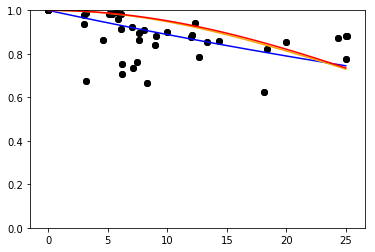

In [20]:
#plotting the graphs with covariance models for space

#Separable
def covariance_func_sep(b, a, c, t, h):
    return np.exp(-b * h)* np.exp(-a * t) # t%T modulo operator returns 

#Non-separable
#Note σ^2=1

def covariance_func_non_sep1(b, a, c, t, h):
    return (a*t+1)/(((((a*t)+1)**2) + (b**2 * h**2))**(2))

def covariance_func_non_sep2(b, a, c, t, h):
    return np.exp(-b**2 * h**2)* np.exp(-a * t) * np.exp(-c * t * h**2)

h = np.linspace(0,25,100)


t = 0
c =0 


b_sep = 0.01177238
a_sep = 0.27165709
plt.plot(h,covariance_func_sep(b_sep, a_sep, c, t, h), color = 'blue')

b_nsep1 = 0.0165161
a_nsep1 = 0.1028079
plt.plot(h,covariance_func_non_sep1(b_nsep1, a_nsep1, c, t, h), color = 'orange')


b_nsep2 = 0.02219538
a_nsep2 = 0.03891541     
c = 0.00316325
plt.plot(h,covariance_func_non_sep2(b_nsep2, a_nsep2, c, t, h), color = 'red')

plt.scatter(tx0, ty0,  color='black')
plt.ylim(0, 1)

#np.savetxt("Temperature_space.csv", np.transpose([h,covariance_func_sep(b_sep, a_sep, c, t, h),
#                                               covariance_func_non_sep1(b_nsep1, a_nsep1, c, t, h),
#                                              covariance_func_non_sep2(b_nsep2, a_nsep2, c, t, h)]), delimiter=",")

#np.savetxt("Temperature_space_data_points.csv", np.transpose([tx0, ty0]), delimiter=",")

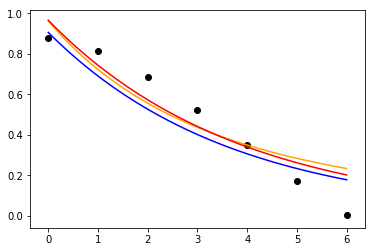

In [21]:
#plotting the graphs with covariance models in time

h_avg = 8.38666666667

t = np.linspace(0,6,100)

b_sep = 0.01177238
a_sep = 0.27165709
plt.plot(t,covariance_func_sep(b_sep, a_sep, c, t, h_avg), color = 'blue')

b_nsep1 = 0.0165161
a_nsep1 = 0.1028079
plt.plot(t,covariance_func_non_sep1(b_nsep1, a_nsep1, c, t, h_avg), color = 'orange')

b_nsep2 = 0.02219538
a_nsep2 = 0.03891541     
c = 0.00316325
plt.plot(t,covariance_func_non_sep2(b_nsep2, a_nsep2, c, t, h_avg), color = 'red')

plt.scatter(temperature_timex, temperature_timey,  color='black')

#np.savetxt("Temperature_time.csv", np.transpose([t,covariance_func_sep(b_sep, a_sep, c, t, h_avg),
#                                               covariance_func_non_sep1(b_nsep1, a_nsep1, c, t, h_avg),
#                                              covariance_func_non_sep2(b_nsep2, a_nsep2, c, t, h_avg)]), delimiter=",")

#np.savetxt("Temperature_time_data_points.csv", np.transpose([temperature_timex, temperature_timey]), delimiter=",")

In [22]:
#Testing which covariance model fits the data points best

sum_cov1 = 0
sum_cov2 = 0
sum_cov3 = 0


#merge

tx = [tx0, tx1, tx2, tx3, tx4, tx5, tx6]#, tx7, tx8, tx9]
ty = [ty0, ty1, ty2, ty3, ty4, ty5, ty6]#, ty7, ty8, ty9]

#print(covariance_func_non_sep1(b_sep, a_sep, c, 0, 0))
#for i in range(len(hx)):
for i in range(7):
    for j in range(len(tx0)):
        #separable
        b_sep = 0.01177238
        a_sep = 0.27165709
        sum_cov1 += np.abs(ty[i][j] - covariance_func_sep(b_sep, a_sep, c, i, tx[i][j]))

        #non-separable I
        b_sep = 0.0165161
        a_sep = 0.102808
        #print(covariance_func_non_sep2(b_sep, a_sep, c, i, hx[i][j]))
        sum_cov2 += np.abs(ty[i][j] - covariance_func_non_sep1(b_sep, a_sep, c, i, tx[i][j]))
        
        #non-separable II
        b_sep = 0.02219538
        a_sep = 0.03891541     
        c = 0.00316325
        #print(covariance_func_non_sep1(b_sep, a_sep, c, i, hx[i][j]))
        sum_cov3 += np.abs(ty[i][j] - covariance_func_non_sep2(b_sep, a_sep, c, i, tx[i][j]))

print(sum_cov1)
print(sum_cov2)
print(sum_cov3) 

70.82288890308116
73.70776392699986
132.36309105148476


(0, 1)

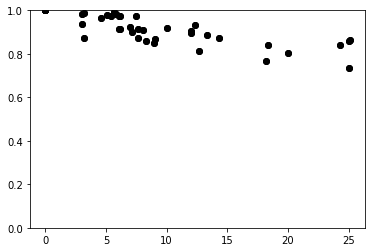

In [23]:
# calculating the covariance for zero lag for Humidity
i = 0

hy0 = [None] * 81
hx0 = [None] * 81
k=0
for first_column in Humidity_data:
    df1 = Humidity_data[first_column]
    std_test1=np.std(df1)
    j = 0 
    for second_column in Humidity_data:
            df2 = Humidity_data[second_column]
            std_test2=np.std(df2)
            hy0[k] = np.corrcoef(df1, df2)[0, 1]
            hx0[k] = nodes_distances.iloc[i,j]
            j = j + 1
            k = k + 1
    i = i + 1
plt.scatter(hx0, hy0,  color='black')
plt.ylim(0, 1)

(0, 1)

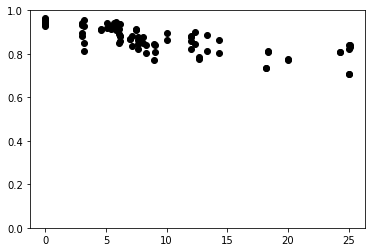

In [24]:
# calculating the covariance for lag 1 hour for Humidity
i = 0

hy1 = [None] * 81
hx1 = [None] * 81
k=0
for first_column in Humidity_data:
    df1 = Humidity_data[first_column][:-1]
    std_test1=np.std(df1)
    j = 0 
    for second_column in Humidity_data:
        df2 = Humidity_data[second_column][1:]
        std_test2=np.std(df2)
        hy1[k] = np.corrcoef(df1, df2)[0, 1]
        hx1[k] = nodes_distances.iloc[i,j]
        j = j + 1
        k = k + 1
    i = i + 1
plt.scatter(hx1, hy1,  color='black')
plt.ylim(0, 1)

(0, 1)

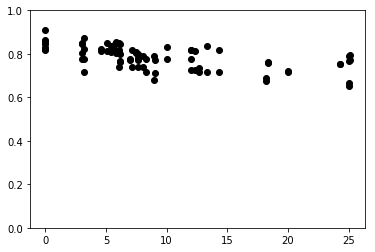

In [25]:
# calculating the covariance for lag 2 hour for Humidity
i = 0

hy2 = [None] * 81
hx2 = [None] * 81
k=0
for first_column in Humidity_data:
    df1 = Humidity_data[first_column][:-2]
    std_test1=np.std(df1)
    j = 0 
    for second_column in Humidity_data:
        df2 = Humidity_data[second_column][2:]
        std_test2=np.std(df2)
        hy2[k] = (np.cov(df1,df2)/(std_test1*std_test2)).item((0, 1))
        hx2[k] = nodes_distances.iloc[i,j]
        j = j + 1
        k = k + 1
    i = i + 1
plt.scatter(hx2, hy2,  color='black')
plt.ylim(0, 1)

(0, 1)

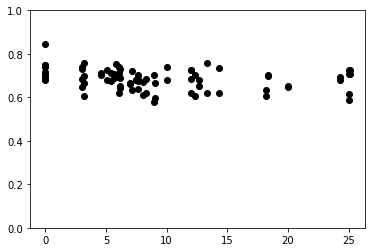

In [26]:
# calculating the covariance for lag 3 hour for Humidity
i = 0

hy3 = [None] * 81
hx3 = [None] * 81
k=0
for first_column in Humidity_data:
    df1 = Humidity_data[first_column][:-3]
    std_test1=np.std(df1)
    j = 0 
    for second_column in Humidity_data:
        df2 = Humidity_data[second_column][3:]
        std_test2=np.std(df2)
        hy3[k] = np.corrcoef(df1, df2)[0, 1]
        hx3[k] = nodes_distances.iloc[i,j]
        j = j + 1
        k = k + 1
    i = i + 1
plt.scatter(hx3, hy3,  color='black')
plt.ylim(0, 1)

(0, 1)

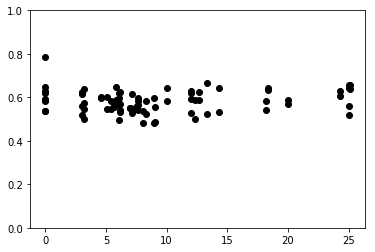

In [27]:
# calculating the covariance for lag 4 hour for Humidity
i = 0

hy4 = [None] * 81
hx4 = [None] * 81
k=0
for first_column in Humidity_data:
    df1 = Humidity_data[first_column][:-4]
    std_test1=np.std(df1)
    j = 0 
    for second_column in Humidity_data:
        df2 = Humidity_data[second_column][4:]
        std_test2=np.std(df2)
        hy4[k] = np.corrcoef(df1, df2)[0, 1]
        hx4[k] = nodes_distances.iloc[i,j]
        j = j + 1
        k = k + 1
    i = i + 1
plt.scatter(hx4, hy4,  color='black')
plt.ylim(0, 1)

(0, 1)

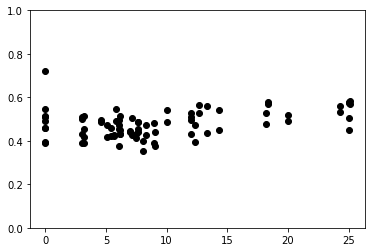

In [28]:
# calculating the covariance for lag 5 hour for Humidity
i = 0

hy5 = [None] * 81
hx5 = [None] * 81
k=0
for first_column in Humidity_data:
    df1 = Humidity_data[first_column][:-5]
    std_test1=np.std(df1)
    j = 0 
    for second_column in Humidity_data:
        df2 = Humidity_data[second_column][5:]
        std_test2=np.std(df2)
        hy5[k] = np.corrcoef(df1, df2)[0, 1]
        hx5[k] = nodes_distances.iloc[i,j]
        j = j + 1
        k = k + 1
    i = i + 1
plt.scatter(hx5, hy5,  color='black')
plt.ylim(0, 1)

In [29]:
#Time lags from 6 to 9

lists_hy = []
lists_hx = []
    
for z in range(4):
    humy = [None] * 81
    humx = [None] * 81
    k=0
    i=0
    for first_column in Humidity_data:
        df1 = Humidity_data[first_column][:-(6+z)]
        std_test1=np.std(df1)
        j = 0 
        for second_column in Humidity_data:
            df2 = Humidity_data[second_column][(6+z):]
            std_test2=np.std(df2)
            humy[k] = np.corrcoef(df1, df2)[0, 1]
            humx[k] = nodes_distances.iloc[i,j]
            j = j + 1
            k = k + 1
        i = i + 1
    lists_hy.append(humy)
    lists_hx.append(humx)

hy6 = lists_hy[0]
hx6 = lists_hx[0]
hy7 = lists_hy[1]
hx7 = lists_hx[1]
hy8 = lists_hy[2]
hx8 = lists_hx[2]
hy9 = lists_hy[3]
hx9 = lists_hx[3]

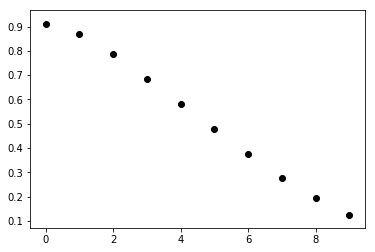

In [30]:
#Calculating averages for time component:
humidity_timey = [sum(hy0)/len(hy0),sum(hy1)/len(hy1), sum(hy2)/len(hy2),sum(hy3)/len(hy3),sum(hy4)/len(hy4),sum(hy5)/len(hy5),
                 sum(hy6)/len(hy6),sum(hy7)/len(hy7),sum(hy8)/len(hy8),sum(hy9)/len(hy9)]

#print(humidity_timey)

humidity_timex = [0,1,2,3,4,5,6,7,8,9]

plt.scatter(humidity_timex, humidity_timey,  color='black')

In [31]:
#Fitting the curve for seperable covariance function

def covariance_func_space(x, b):
    return np.exp(-b * x)

def covariance_func_time(x, a):
    return np.exp(-a * x)

#Fit for the parameters a, b of the function func:

popt, pcov = curve_fit(covariance_func_space, hx0, hy0, bounds=(0, 1))
print(popt)

popt, pcov = curve_fit(covariance_func_time, humidity_timex, humidity_timey, bounds=(0, 1))
print(popt)

[0.00965808]
[0.16429295]


In [32]:
#Fitting the curve for non-seperable covariance function I 

#The first step is determine spatial parameter b
def covariance_func_space(x, b):
    return np.exp(-b**2 * x**2)

popt, pcov = curve_fit(covariance_func_space, hx0, hy0, bounds=(0, 1))
print(popt)


[0.02149839]


In [33]:
#The second step is determine time parameter a and parameter c

def covariance_func_time(x, a, c):
    return np.exp(-a * x - 0.02134169**2 * 8.38666666667**2-c*x*8.38666666667**2)

#Fit for the parameters a, c of the function func:

popt, pcov = curve_fit(covariance_func_time, humidity_timex, humidity_timey, bounds=(0, [0.5, 0.5]))
print(popt)

[0.00315899 0.00219787]


In [34]:
#Fitting the curve for non-seperable covariance function II 

#The first step is determine spatial parameter b
def covariance_func_space(x, b):
    return 1/(1+b**2 * x**2)**2

popt, pcov = curve_fit(covariance_func_space, hx0, hy0, bounds=(0, 0.5))
print(popt)

[0.01581869]


In [35]:
#The second step is determine time parameter a
def covariance_func_time(x, a):
    return (a*x+1)/((1+a * x)**2 + (8.38666666667**2 * 0.01569255**2))**2

#Fit for the parameters a, b of the function func:

popt, pcov = curve_fit(covariance_func_time, humidity_timex, humidity_timey, bounds=(0, 0.5))
print(popt)

[0.06137028]


(0, 1)

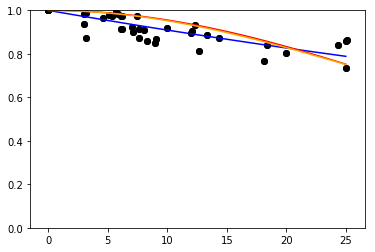

In [36]:
#plotting the graphs with covariance models

h = np.linspace(0,25,100)

t = 0

#covariance_func_sep(b_sep, a_sep, c, t, h)

b_sep = 0.00949773
a_sep = 0.16580629

plt.plot(h,covariance_func_sep(b_sep, a_sep, c, t, h), color='blue')
b_nsep2 = 0.02134169
a_nsep2 = 0.0224028
c = 0.00194497

plt.plot(h,covariance_func_non_sep2(b_nsep2, a_nsep2, c, t, h), color='red')

b_nsep1 = 0.01569255
a_nsep1 = 0.06205185
plt.plot(h,covariance_func_non_sep1(b_nsep1, a_nsep1, c, t, h), color='orange')

plt.scatter(hx0, hy0,  color='black')
plt.ylim(0, 1)

#Save to .csv file
#np.savetxt("Humidity_space.csv", np.transpose([h,covariance_func_sep(b_sep, a_sep, c, t, h),
#                                               covariance_func_non_sep1(b_nsep1, a_nsep1, c, t, h),
#                                              covariance_func_non_sep2(b_nsep2, a_nsep2, c, t, h)]), delimiter=",")

#np.savetxt("Humidity_space_data_points.csv", np.transpose([hx0, hy0,]), delimiter=",")

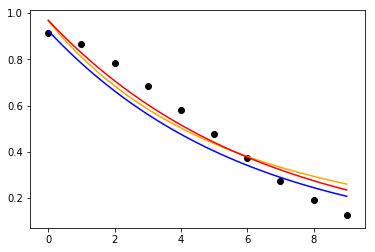

In [37]:
#plotting the graphs with covariance models in time

h_avg = 8.33

t = np.linspace(0,9,100)


b_sep = 0.00949773
a_sep = 0.16580629

plt.plot(t,covariance_func_sep(b_sep, a_sep, c, t, h_avg), color='blue')

b_nsep1 = 0.01569255
a_nsep1 = 0.06205185
plt.plot(t,covariance_func_non_sep1(b_nsep1, a_nsep1, c, t, h_avg), color='orange')


b_nsep2 = 0.02134169
a_nsep2 = 0.0224028
c = 0.00194497

plt.plot(t,covariance_func_non_sep2(b_nsep2, a_nsep2, c, t, h_avg), color='red')


plt.scatter(humidity_timex, humidity_timey,  color='black')

#Save to .csv file
#np.savetxt("Humidity_time.csv", np.transpose([t,covariance_func_sep(b_sep, a_sep, c, t, h_avg),
#                                               covariance_func_non_sep1(b_nsep1, a_nsep1, c, t, h_avg),
#                                              covariance_func_non_sep2(b_nsep2, a_nsep2, c, t, h_avg)]), delimiter=",")

#np.savetxt("Humidity_time_data_points.csv", np.transpose([humidity_timex, humidity_timey]), delimiter=",")

In [38]:
#Testing which covariance model fits the data points best

sum_cov1 = 0
sum_cov2 = 0
sum_cov3 = 0


#merge

hx = [hx0, hx1, hx2, hx3, hx4, hx5, hx6, hx7, hx8, hx9]
hy = [hy0, hy1, hy2, hy3, hy4, hy5, hy6, hy7, hy8, hy9]

#print(covariance_func_non_sep1(b_sep, a_sep, c, 0, 0))
#for i in range(len(hx)):
for i in range(10):
    for j in range(len(hx0)):
        #separable
        b_sep = 0.00949773
        a_sep = 0.013360025
        sum_cov1 += np.abs(hy[i][j] - covariance_func_sep(b_sep, a_sep, c, i, hx[i][j]))
        #print(np.abs(hy[i][j] - covariance_func_sep(b_sep, a_sep, c, i, hx[i][j])))

        #non-separable I
        b_nsep1 = 0.01569255
        a_nsep1 = 0.06205185
        #print(np.abs(hy[i][j] - covariance_func_non_sep2(b_nsep2, a_nsep2, c, i, hx[i][j])))
        sum_cov2 += np.abs(hy[i][j] - covariance_func_non_sep1(b_nsep1, a_nsep1, c, i, hx[i][j]))
        
        #non-separable II
        b_nsep2 = 0.02134169
        a_nsep2 = 0.0224028
        c = 0.00194497
        #print(covariance_func_non_sep1(b_sep, a_sep, c, i, hx[i][j]))
        #print(np.abs(hy[i][j] - covariance_func_non_sep1(b_nsep1, a_nsep1, c, i, hx[i][j])))
        sum_cov3 += np.abs(hy[i][j] - covariance_func_non_sep2(b_nsep2, a_nsep2, c, i, hx[i][j]))


print(sum_cov1)
print(sum_cov2)
print(sum_cov3) 

275.56725209700386
76.95682269654733
194.04063900591615
